In [1]:
from param_sm_pdf import Processor
from sswm import SM_A
from datetime import datetime
from pickle import dump, load
from os import path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cumfreq
import sys

% matplotlib inline

In [62]:
with open(path.join('iterables', 'example_input.pickle'), 'wb') as f:
    dump(iterables, f)

In [63]:
iterables = np.load(path.join('iterables', 'example_input.pickle'))

In [2]:
num_pl = 3                          # number of threads
samples = 20000                     # number of sample simulations per thread
max_num_pl = 10                     # max number of total run samples possible
n_pl_min = num_pl                   # min number of converged run samples to provide results
burnin = 1. / 2.                    # Fraction of burn in period
efficiency_lim = [1, 90]            # limits of MH-MCMC acceptable efficiency

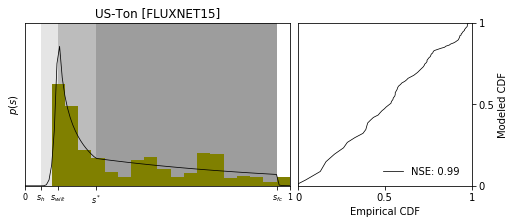

In [64]:
# annual model
model_params_estimate_annual = ['e_max', 's_wilt','s_star'] # use names consistent with script dict  
processor = Processor(model_params_estimate_annual)
loc_res = example_inversion(iterables[0])
plot_p(loc_res)

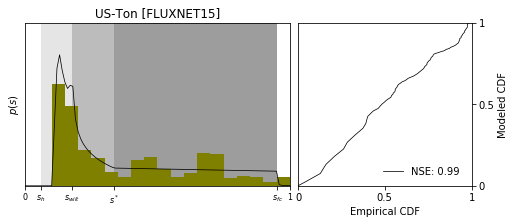

In [66]:
# model with dry season of td days
model_params_estimate_seasonal = ['e_max', 'e_max_dry', 's_wilt','s_star']  
processor = Processor(model_params_estimate_seasonal)
loc_res = example_inversion(iterables[1])
plot_p(loc_res)

In [5]:
def example_inversion(loc_res):
    dt0 = datetime.now()
    theta0 = {'s_wilt': loc_res['s_wilt'],
              's_star': loc_res['s_star'], 
              'delta': loc_res['delta'],
              'rf_lambda': loc_res['rf_lambda'],
              'rf_alpha': loc_res['rf_alpha'],
              'Zr': loc_res['Zr'],
              'a': loc_res['a'],
              'b': loc_res['b'],
              'Ks': loc_res['Ks'],
              'n': loc_res['n'],
              's_h': loc_res['s_h'],
              's_fc': loc_res['s_fc'],
              'f_w': loc_res['f_w'],
              'e_max': loc_res['e_max'],
              'e_max_dry': loc_res['e_max_dry'],
              't_d': loc_res['t_d']
             }

    p_ranges = {'s_wilt': [loc_res['s_h'], loc_res['s_fc']], 
                's_star': [loc_res['s_h'], loc_res['s_fc']],
                'e_max': [0., 10.],
                'e_max_dry': [0., 10.],
                'f_w': [0., 0.5],
                'Zr': [20, 600]}
                # add ranges as necessary to optimize for other variables

    pl_results, n_it, fail_conv_count, fail_eff_count = processor.get_mcmc_mh_results(
                                                            loc_res['s_obs'], 
                                                            theta0, p_ranges,
                                                            nbr_sim=samples, 
                                                            num_pl=num_pl,
                                                            burnin=burnin,
                                                            max_num_pl=max_num_pl,
                                                            efficiency_lim=efficiency_lim)
    loc_res['n_it'] = n_it
    loc_res['num_pl'] = len(pl_results)
    loc_res['fail_conv_count'] = fail_conv_count
    loc_res['fail_eff_count'] = fail_eff_count

    if loc_res['num_pl'] == n_pl_min:
        loc_res = processor.process_raw_results(loc_res, 
                                                pl_results,
                                                outfile_format=outfile_format)

    loc_res['ctime'] = (datetime.now() - dt0).seconds / 60.
    loc_res['fail_conv_count'] = fail_conv_count + loc_res['fail_conv_count']
    loc_res['fail_eff_count'] = fail_eff_count + loc_res['fail_eff_count']
    
    return loc_res

In [21]:
def plot_p(dfi):
    bins = np.linspace(0, 1, 21)
    s_list = np.linspace(0, 1, 101)
    p_fitted_norm, smpdf = get_p_fitted(dfi)
    p_fitted_norm = p_fitted_norm * 100.
    l_cdf_m = 101
    cdf_m = np.cumsum(p_fitted_norm)
    cdf_m_n = cdf_m / np.max(cdf_m)
    cumfreqs_e, lowlim_e, binsize_e, extrapoints_e = cumfreq(loc_res['s_obs'], 
                                                             numbins=l_cdf_m, 
                                                             defaultreallimits=[0, 1])
    cumfreqs_e = np.array(cumfreqs_e) / np.max(cumfreqs_e)
    
    fig = plt.figure(figsize=(8, 3))
    axp = plt.subplot2grid((1, 5), (0, 0), colspan=3)
    axq = plt.subplot2grid((1, 5), (0, 3), colspan=2)
    
    axp.fill_between([dfi['s_h'], dfi['s_fc']], [0, 0], [7, 7], color='grey', alpha=0.2, lw=0)
    axp.fill_between([dfi['s_wilt'], dfi['s_fc']], [0, 0], [7, 7], color='grey', alpha=0.4, lw=0)
    axp.fill_between([dfi['s_star'], dfi['s_fc']], [0, 0], [7, 7], color='grey', alpha=0.5, lw=0)
    axp.hist(loc_res['s_obs'], bins, normed=1, edgecolor='None', facecolor='olive')
    axp.plot(s_list, p_fitted_norm, color='k', lw=0.75)
    axp.set_yticks([])
    axp.set_xticks([0, dfi['s_h'], dfi['s_wilt'], dfi['s_star'], dfi['s_fc'],1])
    axp.set_ylabel(r'$p(s)$')
    axp.set_xticklabels(['0', '$s_{h}$', '$s_{wilt}$', '$s^*$',  '$s_{fc}$', '1'], fontsize=8)
    axp.set_xlabel('')
    axp.set_ylim([0, 7])
    axp.set_xlim([0, 1])
    axp.set_title('%s [%s]' % (dfi['site_name'], dfi['scale']))
    
    axq.plot(cumfreqs_e, cdf_m_n, lw=0.75, color='k', label = 'NSE: %-5.2f' % (dfi['NSE']))
    axq.yaxis.tick_right()
    axq.set_xlim([0, 1])
    axq.set_ylim([0, 1])
    axq.set_xticks([0, 0.5, 1])
    axq.set_xticklabels(['0', 0.5, '1'], fontsize=10)
    axq.set_yticklabels(['0', 0.5, '1'], fontsize=10)
    axq.set_yticks([0, 0.5, 1])
    axq.set_xlabel('Empirical CDF')
    axq.set_ylabel('Modeled CDF')
    axq.yaxis.set_label_position('right')
    plt.legend(frameon=False, loc='lower right')
    
    fig.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

In [7]:
def get_p_fitted(dfi):
    theta_l = [loc_res['s_h'], loc_res['s_wilt'], loc_res['s_star'], loc_res['s_fc'],
                   loc_res['e_max'],  loc_res['f_w'], 
                   loc_res['rf_alpha'], loc_res['rf_lambda'], loc_res['delta'],
                   loc_res['a'], loc_res['b'], loc_res['Ks'], loc_res['n'], loc_res['Zr'],
                   loc_res['e_max_dry'], loc_res['t_d']]
    smpdf = SM_A(theta_l)
    p_fitted_norm = smpdf.get_p0()
    return p_fitted_norm, smpdf